In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import freqz

# =========================================================
# 差分方程（磁编码器）：
# y[n] = (k_p + k_p*k_i**2) x[n] - k_p x[n-1] \
#        - (k_p + k_p*k_i**2 - 2) y[n-1] - (1 - k_p) y[n-2]
#
# 标准IIR形式： a0 y[n] + a1 y[n-1] + a2 y[n-2] = b0 x[n] + b1 x[n-1] + b2 x[n-2]
# 对应系数：
# a0 = 1
# a1 = (k_p + k_p*k_i**2 - 2)
# a2 = (1 - k_p)
# b0 = (k_p + k_p*k_i**2)
# b1 = (-k_p)
# b2 = 0
# =========================================================

def pid_coeffs(kp: float, ki: float):
    """根据磁编码器参数生成 (b, a) 系数"""
    b0 = kp * (1.0 + ki**2)
    b1 = -kp
    b2 = 0.0
    a0 = 1.0
    a1 = kp * (1.0 + ki**2) - 2.0
    a2 = 1.0 - kp
    b = np.array([b0, b1, b2], dtype=float)
    a = np.array([a0, a1, a2], dtype=float)
    return b, a

def plot_freq_response_band(b, a, fmin=0.0, fmax=0.05, N=8192, fs=1.0):
    # 在 [fmin, fmax] 内生成 N 个频率点（单位与 fs 一致，这里是 cycles/sample）
    freqs = np.linspace(fmin, fmax, N)
    w, h = freqz(b, a, worN=freqs, fs=fs)

    mag_db = 20 * np.log10(np.maximum(np.abs(h), 1e-12))
    phase = np.unwrap(np.angle(h))

    # 幅频（仅显示 0~0.05）
    plt.figure()
    plt.plot(w, mag_db)
    plt.title("Magnitude Response (dB) — zoomed {} ~ {}".format(fmin, fmax))
    plt.xlabel("Frequency (cycles/sample)")
    plt.ylabel("Magnitude (dB)")
    plt.grid(True)
    plt.xlim(fmin, fmax)
    plt.show()

    # 相频（仅显示 0~0.05）
    plt.figure()
    plt.plot(w, phase)
    plt.title("Phase Response (rad) — zoomed {} ~ {}".format(fmin, fmax))
    plt.xlabel("Frequency (cycles/sample)")
    plt.ylabel("Phase (rad)")
    plt.grid(True)
    plt.xlim(fmin, fmax)
    plt.show()

def pole_zero_and_stability(b, a):
    """极零图 + 稳定性检查（|pole|<1 稳定）"""
    zeros = np.roots(b) if len(np.trim_zeros(b, 'b')) > 0 else np.array([])
    poles = np.roots(a)

    th = np.linspace(0, 2*np.pi, 512)
    unit_circle = np.exp(1j * th)

    plt.figure()
    plt.plot(unit_circle.real, unit_circle.imag)     # 单位圆
    if zeros.size > 0:
        plt.scatter(zeros.real, zeros.imag, marker='o', label='Zeros')
    plt.scatter(poles.real, poles.imag, marker='x', label='Poles')
    plt.axhline(0, linewidth=0.5)
    plt.axvline(0, linewidth=0.5)
    plt.gca().set_aspect('equal', 'box')
    plt.title("Pole-Zero Plot (z-plane)")
    plt.xlabel("Real")
    plt.ylabel("Imag")
    plt.grid(True)
    plt.legend()
    plt.show()

    stable = np.all(np.abs(poles) < 1.0)
    print("b =", b)
    print("a =", a)
    print("Poles:", poles)
    print("Zeros:", zeros)
    print("Stable:" if stable else "Unstable:", stable)




calculated fc: 0.019289560474927917


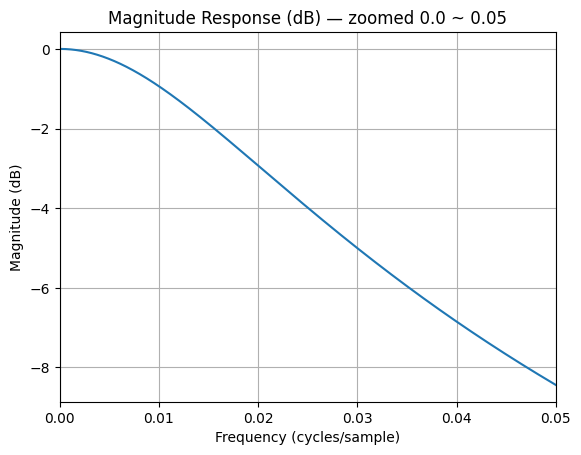

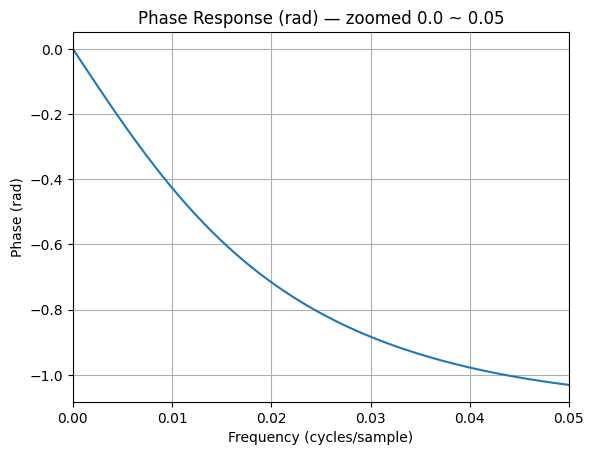

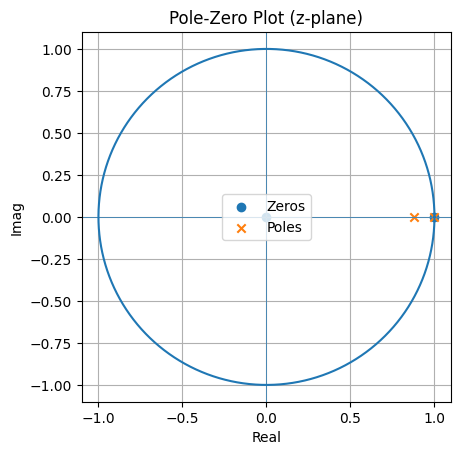

b = [ 0.120012 -0.12      0.      ]
a = [ 1.       -1.879988  0.88    ]
Poles: [0.99989993 0.88008807]
Zeros: [0.99990001 0.        ]
Stable: True


In [2]:
# ===== 示例运行 =====
import math
kp = 0.12 # 1/1024
ki = 0.01 # 1/1024

numerator = (2 * ki + 1) + math.sqrt(8 * ki**2 + 4 * ki + 1)
wc_over_kp = math.sqrt(numerator / 2)
wc = wc_over_kp * kp
fc = wc / (2 * np.pi)
print("calculated fc:", fc)

b, a = pid_coeffs(kp, ki)
plot_freq_response_band(b, a, fmin=0.0, fmax=0.05, N=4096*16, fs=1.0)
pole_zero_and_stability(b, a)

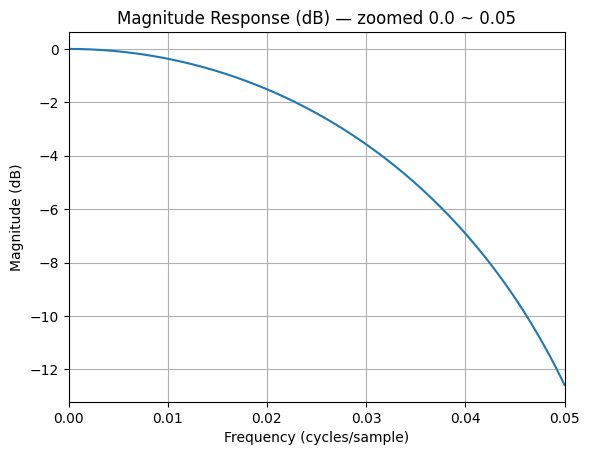

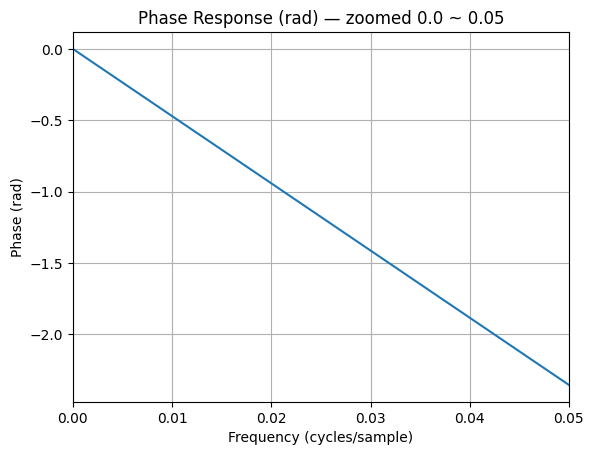

In [12]:
# 定义平均滤波器的系数
window_length = 16  # 窗口长度
b = np.ones(window_length) / window_length  # 平均滤波器的分子系数
a = [1]
plot_freq_response_band(b, a, fmin=0.0, fmax=0.05)